In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st
from toolz import partition

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 14.1 Overdispersion

#### 14.1.2. Data generation

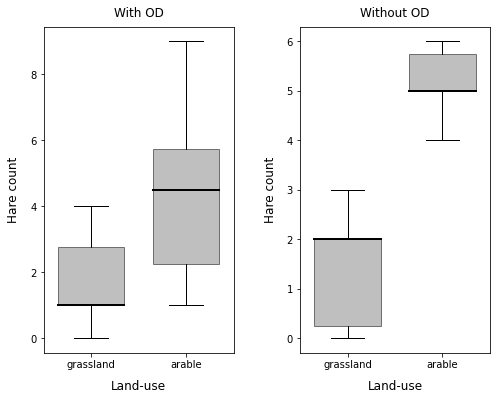

In [10]:
np.random.seed(456)
n_site = 10
x = pd.factorize(np.repeat(("grassland", "arable"), n_site))[0]
eps = st.norm.rvs(0, 0.5, size = 2 * n_site)
λ_OD = np.exp(0.69 + 0.92 * x) + eps
λ_Poisson = np.exp(0.69 + 0.92 * x)

C_OD = st.poisson.rvs(λ_OD, size = 2 * n_site)
C_Poisson = st.poisson.rvs(λ_Poisson, size = 2 * n_site)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), gridspec_kw={'wspace': 0.35})
ax[0].boxplot(list(partition(10, C_OD)), 
                    widths = 0.7, 
                    boxprops = dict(facecolor = 'gray', alpha = 0.5),
                    medianprops = dict(linestyle='-', linewidth=2, color='black'),
                    patch_artist=True, 
                    labels = ['grassland', 'arable'])
ax[0].set_title('With OD', fontsize = 12, pad = 10)
ax[0].set_xlabel('Land-use', fontsize = 12, labelpad = 10)
ax[0].set_ylabel('Hare count', fontsize = 12, labelpad = 10)

ax[1].boxplot(list(partition(10, C_Poisson)), 
                    widths = 0.7, 
                    boxprops = dict(facecolor = 'gray', alpha = 0.5),
                    medianprops = dict(linestyle='-', linewidth=2, color='black'),
                    patch_artist=True, 
                    labels = ['grassland', 'arable'])
ax[1].set_title('Without OD', fontsize = 12, pad = 10)
ax[1].set_xlabel('Land-use', fontsize = 12, labelpad = 10)
ax[1].set_ylabel('Hare count', fontsize = 12, labelpad = 10);

#### 14.1.3 Analysis using PyMC3

In [12]:
with pm.Model() as model_14_1_4:
    alpha = pm.Normal('alpha', 0, tau = 0.001)
    beta = pm.Normal('beta', 0, tau = 0.001)
    sigma = pm.Uniform('sigma', 0, 10)
    
    eps = pm.Normal('eps', 0, sigma = sigma, shape = len(x))
    λ = pm.math.exp(alpha + beta * x + eps)
    C_OD_pred = pm.Poisson('C_OD_pred', λ, observed = C_OD)
    trace_14_1_4 = pm.sample(4000, tune = 3000, target_accept = 0.95, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, sigma, beta, alpha]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 48 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [13]:
az.summary(trace_14_1_4, var_names = ['~eps'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.341,0.314,-0.233,0.950,0.006,0.004,3142.0,3102.0,1.0
beta,1.073,0.376,0.348,1.766,0.006,0.005,3622.0,3535.0,1.0
sigma,0.439,0.226,0.058,0.830,0.008,0.006,580.0,447.0,1.0


### 14.2. Zero-inflation

#### 14.2.2 Data generation

In [14]:
np.random.seed(12345)
psi = 0.8
n_site = 20
x = pd.factorize(np.repeat(("grassland", "arable"), n_site))[0]
w = st.bernoulli.rvs(p = psi, size = 2 * n_site)
λ = np.exp(0.69 + 0.92 * x)
C = st.poisson.rvs(w * λ, size = 2 * n_site)

In [17]:
#plt.figure(figsize = (8, 6))
#plt.hist(C, color= 'gray', edgecolor='black', alpha = 0.5)

#### 14.2.4 Analysis using PyMC3

In [16]:
with pm.Model() as ZIP:
    alpha = pm.Normal('alpha', 0, tau = 0.001)
    beta = pm.Normal('beta', 0, tau = 0.001)
    psi = pm.Uniform('psi', 0, 1)
    R_lpsi = pm.Deterministic('R_lpsi', pm.math.logit(1 - psi))
    λ = pm.math.exp(alpha + beta * x)
    w = pm.Bernoulli('w', psi, initval = w, shape = len(x))

    C_pred = pm.Poisson('C_like', w * λ, observed = C)
    trace_ZIP = pm.sample(3000, tune = 3000, return_inferencedata = True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [psi, beta, alpha]
>BinaryGibbsMetropolis: [w]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 47 seconds.


In [18]:
az.summary(trace_ZIP, var_names = ['alpha', 'beta', 'psi', 'R_lpsi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.814,0.196,0.453,1.179,0.005,0.003,1887.0,2796.0,1.0
beta,0.819,0.227,0.417,1.263,0.005,0.004,1971.0,2554.0,1.0
psi,0.761,0.073,0.619,0.892,0.002,0.001,2211.0,2452.0,1.0
R_lpsi,-1.206,0.428,-2.005,-0.429,0.009,0.007,2211.0,2452.0,1.0


In [19]:
with pm.Model() as ZIP1:
    alpha = pm.Normal('alpha', 0, tau = 0.001)
    beta = pm.Normal('beta', 0, tau = 0.001)
    psi = pm.Beta('psi', 1, 1)
    R_lpsi = pm.Deterministic('R_lpsi', pm.math.logit(1 - psi))
    λ = pm.math.exp(alpha + beta * x)
    
    C_pred = pm.ZeroInflatedPoisson('C_like', psi, λ, observed = C)
    trace_ZIP1 = pm.sample(2000, target_accept = 0.99, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [psi, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 33 seconds.


In [21]:
az.summary(trace_ZIP1, var_names = ['alpha', 'beta', 'psi', 'R_lpsi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.821,0.195,0.452,1.184,0.006,0.004,1160.0,1602.0,1.0
beta,0.812,0.226,0.402,1.254,0.007,0.005,1194.0,1742.0,1.0
psi,0.760,0.073,0.620,0.890,0.002,0.001,1742.0,1746.0,1.0
R_lpsi,-1.196,0.423,-1.943,-0.376,0.010,0.008,1742.0,1746.0,1.0


### 14.3 Offsets

#### 14.3.2 Data Generation

In [22]:
np.random.seed(123456)
n_site = 10
A = st.uniform.rvs(2, 3, size = 2 * n_site)       # Areas range in size from 2 to 5 km2
x = pd.factorize(np.repeat(("grassland", "arable"), n_site))[0]
linear_predictor = np.log(A) + 0.69 + 0.92 * x
λ = np.exp(linear_predictor)
C = st.poisson.rvs(λ, size = 2 * n_site)

In [23]:
#plt.figure(figsize = (8, 6))
#plt.hist(C, color= 'gray', edgecolor='black', alpha = 0.5)

#### 14.3.4 Analysis using PyMC3

In [24]:
with pm.Model() as Offset:
    alpha = pm.Normal('alpha', 0, tau = 0.001)
    beta = pm.Normal('beta', 0, tau = 0.001)
    λ = pm.Deterministic('λ', pm.math.exp(1 * np.log(A) + alpha + beta * x))
    C_pred = pm.Poisson('C_pred', λ, observed = C)
    
    trace_Offset = pm.sample(5000, tune = 3000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 29 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
az.summary(trace_Offset, var_names = ['alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.701,0.123,0.45,0.915,0.003,0.002,2078.0,2812.0,1.0
beta,0.964,0.145,0.70,1.241,0.003,0.002,2031.0,2828.0,1.0


**EXERCISES**

**1.** *Estimating a coefficient for an offset covariate*

In [26]:
with pm.Model() as Offset1:
    omega = pm.Normal('omega', 0, tau = 0.001)
    alpha = pm.Normal('alpha', 0, tau = 0.001)
    beta = pm.Normal('beta', 0, tau = 0.001)
    λ = pm.Deterministic('λ', pm.math.exp(omega * np.log(A) + alpha + beta * x))
    C_pred = pm.Poisson('C_pred', λ, observed = C)
    
    trace_Offset1 = pm.sample(5000, tune = 3000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, omega]


Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 41 seconds.


In [27]:
az.summary(trace_Offset1, var_names = ['omega', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,1.037,0.275,0.527,1.570,0.005,0.004,2909.0,3011.0,1.0
alpha,0.643,0.375,-0.025,1.387,0.007,0.005,2803.0,2790.0,1.0
beta,0.973,0.144,0.703,1.243,0.002,0.001,4835.0,4190.0,1.0


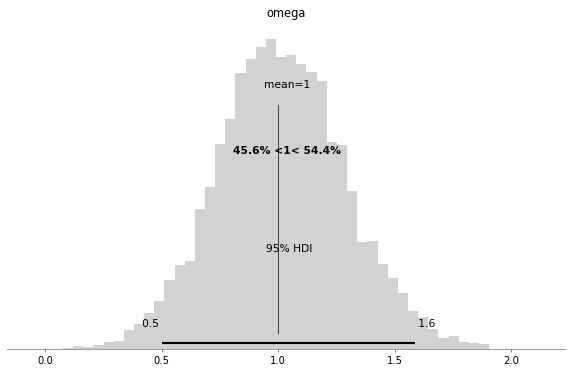

In [28]:
az.plot_posterior(trace_Offset1, 
                  kind = 'hist', 
                  hdi_prob = 0.95, 
                  ref_val = 1,
                  ref_val_color = 'black',
                  bins = 50, 
                  var_names = ['omega'], 
                  figsize = (10, 6), 
                  textsize=10,
                  color = 'gray');